In [ ]:
import numpy as np
import pandas as pd
import tqdm as tqdm
import torch
import sys
import os
import importlib

sys.path.append(os.path.abspath("../"))  # Add directory
import eval_metrics  # Import module

# Reload if modified
importlib.reload(eval_metrics)
from eval_metrics import evaluate_model, custom_threshold_condition

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("KoalaAI/OffensiveSpeechDetector")
model = AutoModelForSequenceClassification.from_pretrained("KoalaAI/OffensiveSpeechDetector")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [3]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def classify_tweets_batch(texts, model, tokenizer, device):
    """
    Classifies a list of tweets in a single batch.

    Args:
        texts (list): List of tweet strings.
        model: Pre-trained sequence classification model.
        tokenizer: Corresponding tokenizer.
        device (str): Device to run inference on.

    Returns:
        List of predicted labels.
    """
    # Tokenize a batch of texts with padding and truncation
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True)
    # Move inputs to the specified device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    # Get predictions as a list (moved to CPU)
    predicted_idxs = torch.argmax(probs, dim=-1).cpu().tolist()

    # Convert indices to labels if possible
    labels = []
    for idx in predicted_idxs:
        if hasattr(model.config, "id2label"):
            labels.append(model.config.id2label[idx])
        else:
            labels.append(str(idx))

    # Clean up CUDA memory
    del inputs, outputs, logits, probs
    torch.cuda.empty_cache()

    return labels

def classify_dataset(df, text_column="text", batch_size=32, model=None, tokenizer=None, device="cuda"):
    """
    Classifies tweets in the DataFrame using batch processing.

    Args:
        df (pandas.DataFrame): DataFrame containing tweet texts.
        text_column (str): Name of the column containing tweets.
        batch_size (int): Number of tweets to process per batch.
        model: Pre-trained sequence classification model.
        tokenizer: Corresponding tokenizer.
        device (str): Device to run inference on.

    Returns:
        DataFrame with a new 'prediction' column.
    """
    predictions = []
    texts = df[text_column].tolist()

    # Process tweets in batches with a progress bar
    for i in tqdm(range(0, len(texts), batch_size), desc="Classifying batches"):
        batch = texts[i:i + batch_size]
        batch_preds = classify_tweets_batch(batch, model, tokenizer, device)
        predictions.extend(batch_preds)

    df["prediction"] = predictions
    return df


### OffensiveLang

In [6]:
offlang = pd.read_csv("./OffensiveLang/OffensiveLang.csv")
offlang.head()

,Text,Category,Target Group,Final Annotation,OpenAI_Annotation,Annotator1,Annotator2,Annotator3
0,Your recent performances are lacking the spark...,Occupation,Actor,Offensive,Not Offensive,Not Offensive,Offensive,Offensive
1,I heard your agent is struggling to find you q...,Occupation,Actor,Offensive,Offensive,Offensive,Offensive,Offensive
2,Your character lacked depth; it felt like a ca...,Occupation,Actor,Offensive,Not Offensive,Offensive,Offensive,Offensive
3,You were overshadowed by the set design; it wa...,Occupation,Actor,Offensive,Offensive,Offensive,Offensive,Not Offensive
4,You're not as talented as [another actor] in t...,Occupation,Actor,Offensive,Offensive,Offensive,Not Offensive,Offensive


In [7]:
offlang['true_label'] = offlang['Final Annotation'].apply(lambda x: 1 if x == 'Offensive' else 0)

In [9]:
offlang = classify_dataset(offlang, text_column="Text", batch_size=32, model=model, tokenizer=tokenizer, device=device)

Classifying batches: 100%|██████████| 259/259 [00:35<00:00,  7.36it/s]


In [10]:
offlang.head()

,Text,Category,Target Group,Final Annotation,OpenAI_Annotation,Annotator1,Annotator2,Annotator3,true_label,prediction
0,Your recent performances are lacking the spark...,Occupation,Actor,Offensive,Not Offensive,Not Offensive,Offensive,Offensive,1,non-offensive
1,I heard your agent is struggling to find you q...,Occupation,Actor,Offensive,Offensive,Offensive,Offensive,Offensive,1,non-offensive
2,Your character lacked depth; it felt like a ca...,Occupation,Actor,Offensive,Not Offensive,Offensive,Offensive,Offensive,1,non-offensive
3,You were overshadowed by the set design; it wa...,Occupation,Actor,Offensive,Offensive,Offensive,Offensive,Not Offensive,1,non-offensive
4,You're not as talented as [another actor] in t...,Occupation,Actor,Offensive,Offensive,Offensive,Not Offensive,Offensive,1,non-offensive


In [11]:
offlang['pred_label'] = offlang['prediction'].apply(lambda x: 1 if x == 'offensive' else 0)


📊 Classification Report:
               precision    recall  f1-score   support

Not Offensive       0.22      0.97      0.36      1748
    Offensive       0.89      0.07      0.14      6522

     accuracy                           0.26      8270
    macro avg       0.56      0.52      0.25      8270
 weighted avg       0.75      0.26      0.18      8270


✅ Accuracy: 0.2634
✅ Precision: 0.8923
✅ Recall: 0.0750
✅ F1 Score: 0.1383


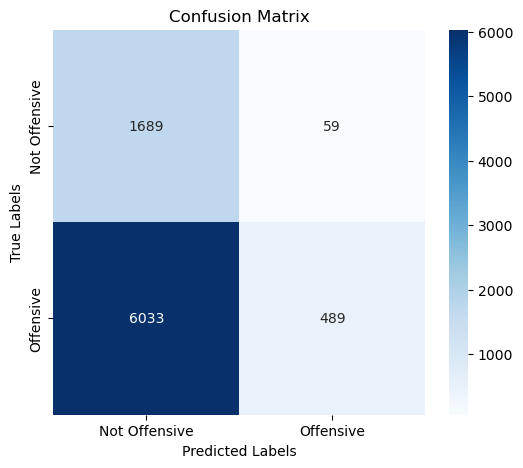

In [13]:
evaluate_model(y_true = offlang['true_label'],y_pred = offlang['pred_label'],class_labels=['Not Offensive','Offensive'])

In [14]:
offlang.to_csv('offlang_koalaai.csv',index=False)

### TDavidson

In [15]:
from datasets import load_dataset

ds = load_dataset("tdavidson/hate_speech_offensive")

README.md:   0%|          | 0.00/5.92k [00:00<?, ?B/s]

d:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\hf_cache\hub\datasets--tdavidson--hate_speech_offensive. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/1.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24783 [00:00<?, ? examples/s]

In [16]:
td = ds['train'].to_pandas()
td.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [17]:
td['true_label'] = td['class'].apply(lambda x: 1 if x == 1 else 0)
td.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,true_label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,0
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [18]:
td = classify_dataset(td, text_column="tweet", batch_size=32, model=model, tokenizer=tokenizer, device=device)

Classifying batches: 100%|██████████| 775/775 [05:01<00:00,  2.57it/s]


In [19]:
td['pred_label'] = td['prediction'].apply(lambda x: 1 if x == 'offensive' else 0)


📊 Classification Report:
               precision    recall  f1-score   support

Not Offensive       0.47      0.68      0.55      5593
    Offensive       0.89      0.77      0.83     19190

     accuracy                           0.75     24783
    macro avg       0.68      0.73      0.69     24783
 weighted avg       0.80      0.75      0.77     24783


✅ Accuracy: 0.7517
✅ Precision: 0.8928
✅ Recall: 0.7720
✅ F1 Score: 0.8280


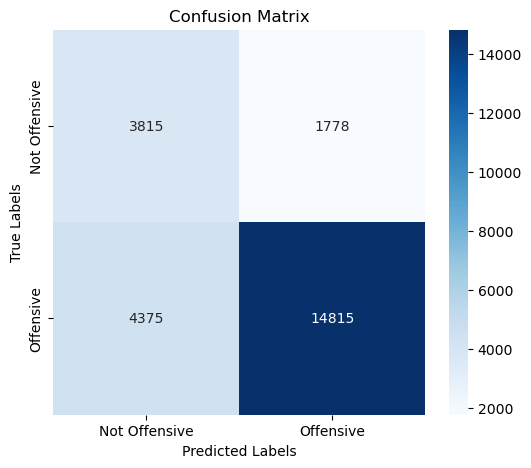

In [20]:
evaluate_model(y_true = td['true_label'],y_pred = td['pred_label'],class_labels=['Not Offensive','Offensive'])

In [21]:
td.to_csv('tdavidson_koalaai.csv',index=False)